# Modelo *RMFT* ($\sigma$-$\omega$) para la EoS de Estrellas de Neutrones

In [1]:
# Importamos las librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.size'] = 15
from scipy.integrate import odeint, quad
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

## Ecuacion de Estado del Modelo

En términos de los campos medios $\sigma$ y $\omega_0$, podemos escribir la densidad de número, la densidad de energía y la presión de la estrella de neutrones como (unidades geometrizadas):

$$ n = \frac{2p_F^3}{3\pi^2\hbar^3} \iff p_F(n) = \left(\frac{3\pi^2\hbar^3 n}{2}\right)^{1/3}$$ 
$$ \rho = \frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F} p^2 \sqrt{p^2 + (m - g_\sigma \sigma)^2} dp$$
$$ P = -\frac{1}{2}\frac{m_\sigma^2}{\hbar^2} \sigma^2 + \frac{1}{2}\frac{m_\omega^2}{\hbar^2} \omega_0^2 - \frac{2}{3\pi^2\hbar^3} \int_0^{p_F} \frac{p^4}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} dk$$

además, el sistema cumple las ecuaciones de campo:

$$ g_\sigma \sigma = \frac{g_\sigma^2}{m_\sigma^2} \frac{2}{\pi^2 \hbar} \int_0^{p_F} \frac{m - g_\sigma \sigma}{\sqrt{p^2 + (m - g_\sigma \sigma)^2}} p^2 dp$$
$$ g_\omega \omega_0 = \frac{g_\omega^2}{m_\omega^2} \hbar^2 n$$

donde $m$ es la masa efectiva de los fermiones, $p_F$ es el momento de Fermi, $g_\sigma$ y $g_\omega$ son las constantes de acoplamiento de los campos $\sigma$ y $\omega$, respectivamente, y $m_\sigma$ y $m_\omega$ son las masas de los campos $\sigma$ y $\omega$. La primera ecuacion presenta un problema de autoconsistencia, ya que $g_\sigma\sigma$ aparece en ambos lados de la ecuación, y puede ser resuelta numéricamente hayando las raices de la ecuación para $g_\sigma \sigma$.  

Ahora bien, tomando $x_\sigma = g_\sigma \sigma$, así como $A_\sigma = \frac{g_\sigma}{m_\sigma}$ y $A_\omega = \frac{g_\omega}{m_\omega}$, podemos reescribir las ecuaciones en términos de las constantes $A_i$ y la densidad bariónica $n$, adimensionalizando las últimas mediante la densidad central $\rho_0$ (mismas unidades de la presión en unidades geometrizadas):

$$ x_\sigma - A_\sigma^2 \frac{2}{\pi^2 \hbar} \int_0^{p_F(n)} \frac{m - x_\sigma}{\sqrt{p^2 + (m - x_\sigma)^2}} p^2 dp = 0$$
$$ \hat\rho = \left[\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 + \frac{2}{\pi^2 \hbar^3} \int_0^{p_F(n)} p^2 \sqrt{p^2 + (m - x_\sigma)^2} dp\right]/\rho_0$$
$$ \hat P = \left[-\frac{1}{2A_\sigma^2\hbar^2} x_\sigma^2 + \frac{1}{2}A_\omega^2\hbar^2 n^2 - \frac{2}{3\pi^2\hbar^3} \int_0^{p_F(n)} \frac{p^4}{\sqrt{p^2 + (m - x_\sigma)^2}} dp\right]/\rho_0$$

In [9]:
# Definimos las constantes necesarias en MKS
hbar_MKS = 1.0545718e-34 # J s
c_MKS = 299792458 # m/s
G_MKS = 6.67430e-11 # m^3/kg/s^2
pi = np.pi
m_nuc_MKS = 1.6726219e-27 # kg

# Definimos las constantes necesarias en unidades geometrizadas
hbar = hbar_MKS * (G_MKS/c_MKS**3) # m^2
m_nuc = m_nuc_MKS * (G_MKS/c_MKS**2) # m

# Damos valores a las constantes
# A_sigma = 1e-7
# A_omega = 1e-7
A_sigma = np.sqrt(266.9*hbar/m_nuc**2)
A_omega = np.sqrt(195.7*hbar/m_nuc**2)

print(A_sigma, A_omega)

2.1257983940942145e+20 1.8203009702331715e+20


In [15]:
autoconsistencia(x_sigma,A_sigma, 1e47)

np.float64(-1.1774374925082483e+163)

In [14]:
# Definimos un algoritmo de solución para la ecuación de autoconsistencia dados n_barion y A_sigma

# Primero el integrando
# def integrando_x_sigma(p, x_sigma):
#     return (m_nuc-x_sigma)*p**2/(p**2 + (m_nuc-x_sigma)**2)

# Ahora la ecuación de autoconsistencia
def autoconsistencia(x_sigma, A_sigma, n_barion):
    p_f = (3*pi**2*hbar**3*n_barion/2)**(1/3) # Momento de Fermi en función de n_barion
    # integral = quad(integrando_x_sigma, 0, p_f, args=(x_sigma))
    integral = -np.sqrt(m_nuc**2+p_f**2-2*m_nuc*x_sigma+x_sigma**2)/(p_f*(m_nuc-x_sigma))
    return x_sigma - A_sigma**2*(2/(pi**2*hbar))*integral

# Función para resolver la ecuación de autoconsistencia para un n_barion y A_sigma dados
def solucion_x_sigma(n_barion, A_sigma):
    return fsolve(autoconsistencia, 1e-20, args=(A_sigma, n_barion))[0]

# Ejemplo
n_barion_max = 1e47
x_sigma = solucion_x_sigma(n_barion_max, A_sigma)
print("x_sigma = ", x_sigma, "para n_barion = ", n_barion_max)

x_sigma =  1e-20 para n_barion =  1e+47


C:\Users\nicom\AppData\Local\Temp\ipykernel_10164\4195994425.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(autoconsistencia, 1e-20, args=(A_sigma, n_barion))[0]


In [7]:
# Definimos las funciones de densidad de energía y presión

def integrando_energia(p, x_sigma):
    return p**2 * (p**2 + (m_nuc-x_sigma)**2)**(1/2)

def integrando_presion(p, x_sigma):
    return p**4 / (p**2 + (m_nuc-x_sigma)**2)**(1/2)

def energia_presion(n_barion, A_sigma, A_omega, rho_0):
    x_sigma = solucion_x_sigma(n_barion, A_sigma)
    p_f = (3*pi**2*hbar**3*n_barion/2)**(1/3) # Momento de Fermi en función de n_barion
    integral_energia = quad(integrando_energia, 0, p_f, args=(x_sigma))[0]
    integral_presion = quad(integrando_presion, 0, p_f, args=(x_sigma))[0]
    energia = (x_sigma**2/(2*A_sigma**2*hbar**2) + 1/2*A_omega**2*hbar**2*n_barion**2 + 2/(pi**2*hbar**3)*integral_energia)/rho_0
    presion = (-x_sigma**2/(2*A_sigma**2*hbar**2) + 1/2*A_omega**2*hbar**2*n_barion**2 + 2/(3*pi**2*hbar**3)*integral_presion)/rho_0
    return energia, presion

def EoS(n_barion, A_sigma, A_omega, rho_0):
    energias = []
    presiones = []
    for n in n_barion:
        energia, presion = energia_presion(n, A_sigma, A_omega, rho_0)
        energias.append(energia)
        presiones.append(presion)
    return interp1d(presiones, energias), presiones, energias

# Ejemplo
n_barion_max = 1e47
energia, presion = energia_presion(n_barion_max, A_sigma, A_omega, 1)
print("Energía = ", energia, "y presión = ", presion, "para n_barion = ", n_barion_max)

Energía =  1.0361298165940198e+45 y presión =  -1.0361298165940198e+45 para n_barion =  1e+47


Densidad central =  1.0361298165940198e+45 para n_barion_max =  1e+47


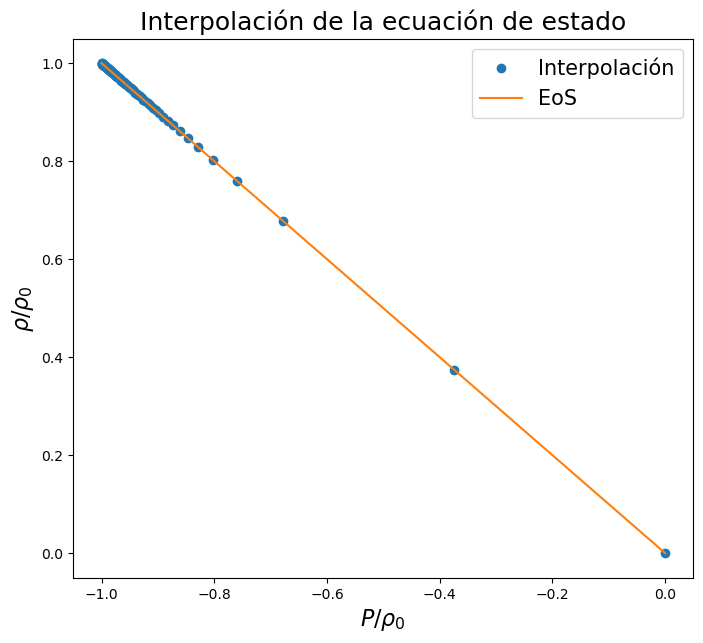

In [8]:
# Calculamos la densidad de energía central para una densidad barionica de 1e47
n_barion_max = 1e47
rho_0, _ = energia_presion(n_barion_max, A_sigma, A_omega, 1)
print("Densidad central = ", rho_0, "para n_barion_max = ", n_barion_max)

# Definimos el rango de densidades barionicas e interpolamos la ecuación de estado
n_barion = np.linspace(0, n_barion_max, 100)
# n_barion = np.logspace(0, np.log10(n_barion_max), 100)
rho_P, presiones, energias = EoS(n_barion, A_sigma, A_omega, rho_0)

# Graficamos la ecuación de estado rho(P)
plt.figure(figsize=(8, 7))
plt.plot(presiones, rho_P(presiones), "o", label='Interpolación')
plt.plot(presiones, energias, label='EoS')
plt.xlabel(r'$P/\rho_0$', fontsize=16)
plt.ylabel(r'$\rho/\rho_0$', fontsize=16)
plt.title('Interpolación de la ecuación de estado', fontsize=18)
plt.legend()
plt.show()